In [ ]:
# ============================================================================
# CELL 1: INSTALLATIONS
# ============================================================================
print("Installing required packages...")

# XGBoost usually pre-installed, but ensuring latest version
!pip install -q xgboost

print("All packages installed successfully!")

Installing required packages...
All packages installed successfully!


In [ ]:
# ============================================================================
# CELL 2: IMPORTS
# ============================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import (
    StratifiedKFold,
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score,
    train_test_split
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    roc_auc_score,
    classification_report,
    confusion_matrix,
    roc_curve
)
import xgboost
from xgboost import XGBClassifier
import time
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

print("All imports successful!")
print(f"XGBoost version: {xgboost.__version__}")

All imports successful!
XGBoost version: 3.0.5


In [ ]:
# ============================================================================
# CELL 3: DEFINE FEATURE SET
# ============================================================================

expected_features = [
    'trigram_diversity', 'yules_k', 'token_burstiness', 'char_trigram_entropy',
    'avg_tree_depth', 'max_tree_depth', 'avg_dependency_distance',
    'uppercase_ratio', 'whitespace_ratio', 'unique_char_count',
    'comma_ratio', 'period_ratio', 'question_ratio', 'exclamation_ratio',
    'semicolon_ratio', 'colon_ratio', 'quote_ratio',
    'sentiment_polarity', 'sentiment_subjectivity', 'sentiment_polarity_variance',
    'neutral_sentence_ratio', 'positive_word_ratio', 'negative_word_ratio',
    'pos_ratio_DET', 'pos_ratio_ADP', 'pos_ratio_AUX', 'pos_ratio_CCONJ',
    'pos_ratio_PART', 'pos_ratio_NUM', 'pos_row_entropy_weighted',
    'function_to_content_rate', 'noun_verb_alternation_rate', 'content_function_ratio',
    'noun_verb_ratio', 'adj_adv_ratio', 'verbs_per_100_tok', 'nouns_per_100_tok',
    'adj_per_100_tok', 'adv_per_100_tok', 'pron_per_100_tok', 'punct_per_100_tok',
    'tokens_per_sentence_mean', 'mean_nouns_per_sent', 'mean_verbs_per_sent',
    'mean_adjs_per_sent', 'mean_advs_per_sent', 'prop_sents_with_verb',
    'unique_upos_per_sent_mean', 'max_runlen_NOUN', 'max_runlen_PUNCT',
    'avg_sentence_length', 'sentence_length_std', 'n_sentences_doc'
]

print(f"✓ Feature set defined: {len(expected_features)} features")

✓ Feature set defined: 53 features


In [ ]:
# ============================================================================
# CELL 4: LOAD DATA AND CREATE TRAIN/TEST SPLIT
# ============================================================================

# Load your data (adjust to your actual loading method)
df = pd.read_csv(r'/content/raid_sample_large_PostPOS_CLEAN.csv')
# Or if df already exists from previous notebook, that's fine

print(f"Dataset shape: {df.shape}")
print(f"Class distribution:\n{df['is_ai'].value_counts()}")

# Prepare data
X = df[expected_features].values
y = df['is_ai'].astype(int).values

print(f"\nData prepared:")
print(f"  Features: {X.shape}")
print(f"  Labels: {y.shape}")
print(f"  Class distribution: AI={y.sum()}, Human={len(y)-y.sum()}")

# IMPORTANT: Create train/test split for 60k samples
print(f"\nCreating train/test split...")
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,      # 20% for test (12,000 samples)
    random_state=42,
    stratify=y
)

print(f"  Training set: {X_train.shape[0]} samples ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"  Test set:     {X_test.shape[0]} samples ({X_test.shape[0]/len(X)*100:.1f}%)")
print(f"  Train class distribution: AI={y_train.sum()}, Human={len(y_train)-y_train.sum()}")
print(f"  Test class distribution:  AI={y_test.sum()}, Human={len(y_test)-y_test.sum()}")
print(f"\n✓ Data ready for hyperparameter search")

Dataset shape: (60000, 86)
Class distribution:
is_ai
True     30000
False    30000
Name: count, dtype: int64

Data prepared:
  Features: (60000, 53)
  Labels: (60000,)
  Class distribution: AI=30000, Human=30000

Creating train/test split...
  Training set: 48000 samples (80.0%)
  Test set:     12000 samples (20.0%)
  Train class distribution: AI=24000, Human=24000
  Test class distribution:  AI=6000, Human=6000

✓ Data ready for hyperparameter search


In [ ]:
# ============================================================================
# CELL 5: DEFINE STREAMLINED HYPERPARAMETER GRIDS (60K OPTIMIZED)
# ============================================================================

print("Creating streamlined parameter grids optimized for 60k samples...")

# Random Forest parameter grid (REDUCED for 60k samples)
# Focus on most impactful parameters
rf_param_grid = {
    'n_estimators': [100, 300, 500],  # Reduced from 5 to 3 options
    'max_depth': [20, 30, None],  # Reduced from 5 to 3 options
    'min_samples_split': [2, 10],  # Reduced from 4 to 2 options
    'min_samples_leaf': [1, 4],  # Reduced from 4 to 2 options
    'max_features': ['sqrt', 0.3],  # Reduced from 4 to 2 options
}

# XGBoost parameter grid (REDUCED for 60k samples)
xgb_param_grid = {
    'n_estimators': [100, 300, 500],
    'max_depth': [5, 7, 9],
    'learning_rate': [0.05, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'min_child_weight': [1, 5],
    'gamma': [0, 0.1]
}

print("\nRandom Forest parameter grid:")
print(f"  Total combinations: {np.prod([len(v) for v in rf_param_grid.values()])}")
for param, values in rf_param_grid.items():
    print(f"  {param}: {values}")

print("\nXGBoost parameter grid:")
print(f"  Total combinations: {np.prod([len(v) for v in xgb_param_grid.values()])}")
for param, values in xgb_param_grid.items():
    print(f"  {param}: {values}")

print(f"\n✓ Streamlined grids for 60k samples")
print(f"  RF: {np.prod([len(v) for v in rf_param_grid.values()])} combinations (was 201,600)")
print(f"  XGB: {np.prod([len(v) for v in xgb_param_grid.values()])} combinations (was 10,080)")

Creating streamlined parameter grids optimized for 60k samples...

Random Forest parameter grid:
  Total combinations: 72
  n_estimators: [100, 300, 500]
  max_depth: [20, 30, None]
  min_samples_split: [2, 10]
  min_samples_leaf: [1, 4]
  max_features: ['sqrt', 0.3]

XGBoost parameter grid:
  Total combinations: 432
  n_estimators: [100, 300, 500]
  max_depth: [5, 7, 9]
  learning_rate: [0.05, 0.1, 0.2]
  subsample: [0.8, 1.0]
  colsample_bytree: [0.8, 1.0]
  min_child_weight: [1, 5]
  gamma: [0, 0.1]

✓ Streamlined grids for 60k samples
  RF: 72 combinations (was 201,600)
  XGB: 432 combinations (was 10,080)


In [ ]:
# ============================================================================
# CELL 6: STRATIFIED SAMPLING + RANDOMIZED SEARCH (MUCH FASTER)
# ============================================================================

print("\n" + "="*70)
print("PHASE 1: FAST HYPERPARAMETER SEARCH WITH STRATIFIED SAMPLING")
print("="*70)
print("\nStrategy: Use 20% sample (12k) for quick search, then validate on full set")
print("This reduces computation time by ~80% while maintaining reliability.\n")

# Create stratified sample for hyperparameter search
from sklearn.model_selection import train_test_split

X_search, _, y_search, _ = train_test_split(
    X_train, y_train,
    train_size=0.2,  # Use 20% for search (9,600 samples)
    random_state=42,
    stratify=y_train
)

print(f"Search sample size: {len(X_search)} (20% of training set)")
print(f"Full training size: {len(X_train)}")

# Setup cross-validation (3-fold for speed)
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Random Forest Randomized Search (on sample)
print("\n" + "-"*70)
print("Random Forest Randomized Search (on 20% sample)")
print("-"*70)

rf_random = RandomizedSearchCV(
    RandomForestClassifier(random_state=42, n_jobs=-1),
    param_distributions=rf_param_grid,
    n_iter=20,  # Reduced from 50 to 20
    cv=cv,
    scoring='f1',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

print("Starting search...")
rf_start = time.time()
rf_random.fit(X_search, y_search)
rf_time = time.time() - rf_start

print(f"\n✓ Random Forest search completed in {rf_time/60:.2f} minutes")
print(f"Best F1 Score (CV on sample): {rf_random.best_score_:.4f}")
print(f"Best parameters:")
for param, value in rf_random.best_params_.items():
    print(f"  {param}: {value}")

# Validate on full training set
print("\nValidating on full training set...")
rf_val_start = time.time()
rf_val_scores = cross_val_score(
    rf_random.best_estimator_,
    X_train, y_train,
    cv=3,
    scoring='f1',
    n_jobs=-1
)
rf_val_time = time.time() - rf_val_start

print(f"Full training set F1: {rf_val_scores.mean():.4f} ± {rf_val_scores.std():.4f}")
print(f"Validation time: {rf_val_time/60:.2f} minutes")
print(f"Total RF time: {(rf_time + rf_val_time)/60:.2f} minutes")

# XGBoost Randomized Search (on sample)
print("\n" + "-"*70)
print("XGBoost Randomized Search (on 20% sample)")
print("-"*70)

xgb_random = RandomizedSearchCV(
    XGBClassifier(random_state=42, n_jobs=-1, eval_metric='logloss', verbosity=0),
    param_distributions=xgb_param_grid,
    n_iter=20,
    cv=cv,
    scoring='f1',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

print("Starting search...")
xgb_start = time.time()
xgb_random.fit(X_search, y_search)
xgb_time = time.time() - xgb_start

print(f"\n✓ XGBoost search completed in {xgb_time/60:.2f} minutes")
print(f"Best F1 Score (CV on sample): {xgb_random.best_score_:.4f}")
print(f"Best parameters:")
for param, value in xgb_random.best_params_.items():
    print(f"  {param}: {value}")

# Validate on full training set
print("\nValidating on full training set...")
xgb_val_start = time.time()
xgb_val_scores = cross_val_score(
    xgb_random.best_estimator_,
    X_train, y_train,
    cv=3,
    scoring='f1',
    n_jobs=-1
)
xgb_val_time = time.time() - xgb_val_start

print(f"Full training set F1: {xgb_val_scores.mean():.4f} ± {xgb_val_scores.std():.4f}")
print(f"Validation time: {xgb_val_time/60:.2f} minutes")
print(f"Total XGB time: {(xgb_time + xgb_val_time)/60:.2f} minutes")

# Summary comparison
print("\n" + "="*70)
print("RANDOMIZED SEARCH SUMMARY")
print("="*70)
print(f"Random Forest:")
print(f"  Sample CV F1:      {rf_random.best_score_:.4f}")
print(f"  Full training F1:  {rf_val_scores.mean():.4f} ± {rf_val_scores.std():.4f}")
print(f"  Total search time: {(rf_time + rf_val_time)/60:.2f} minutes")
print(f"\nXGBoost:")
print(f"  Sample CV F1:      {xgb_random.best_score_:.4f}")
print(f"  Full training F1:  {xgb_val_scores.mean():.4f} ± {xgb_val_scores.std():.4f}")
print(f"  Total search time: {(xgb_time + xgb_val_time)/60:.2f} minutes")

# Store full training scores for later use
rf_random.best_score_full_ = rf_val_scores.mean()
xgb_random.best_score_full_ = xgb_val_scores.mean()

if xgb_val_scores.mean() > rf_val_scores.mean():
    diff = xgb_val_scores.mean() - rf_val_scores.mean()
    print(f"\n✓ XGBoost leads by {diff:.4f} F1 points on full training set")
else:
    diff = rf_val_scores.mean() - xgb_val_scores.mean()
    print(f"\n✓ Random Forest leads by {diff:.4f} F1 points on full training set")


PHASE 1: FAST HYPERPARAMETER SEARCH WITH STRATIFIED SAMPLING

Strategy: Use 20% sample (12k) for quick search, then validate on full set
This reduces computation time by ~80% while maintaining reliability.

Search sample size: 9600 (20% of training set)
Full training size: 48000

----------------------------------------------------------------------
Random Forest Randomized Search (on 20% sample)
----------------------------------------------------------------------
Starting search...
Fitting 3 folds for each of 20 candidates, totalling 60 fits

✓ Random Forest search completed in 14.62 minutes
Best F1 Score (CV on sample): 0.8531
Best parameters:
  n_estimators: 500
  min_samples_split: 2
  min_samples_leaf: 1
  max_features: sqrt
  max_depth: None

Validating on full training set...
Full training set F1: 0.9011 ± 0.0010
Validation time: 5.90 minutes
Total RF time: 20.52 minutes

----------------------------------------------------------------------
XGBoost Randomized Search (on 20% 


PHASE 2: ADAPTIVE PARAMETER REFINEMENT WITH CHECKPOINTS

Strategy: Test 2 RF configs (slow) vs 6 XGB configs (fast)
Checkpoints allow resuming if interrupted.

RANDOM FOREST REFINEMENT (2 configurations)

──────────────────────────────────────────────────────────────────────
Testing RF Config: baseline
Parameters: {'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None}
──────────────────────────────────────────────────────────────────────
Running 3-fold CV on 48000 samples...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.



✓ Config 'baseline' completed in 5.99 minutes
  F1: 0.9021 ± 0.0017
 Checkpoint saved

──────────────────────────────────────────────────────────────────────
Testing RF Config: more_trees
Parameters: {'n_estimators': 700, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None}
──────────────────────────────────────────────────────────────────────
Running 3-fold CV on 48000 samples...


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  6.0min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  8.3min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.



✓ Config 'more_trees' completed in 8.31 minutes
  F1: 0.9018 ± 0.0018
 Checkpoint saved

RANDOM FOREST RESULTS
  baseline       : F1=0.9021 ± 0.0017  (6.0 min)
  more_trees     : F1=0.9018 ± 0.0018  (8.3 min)

✓ Best RF: 'baseline' with F1=0.9021


XGBOOST REFINEMENT (6 configurations)

──────────────────────────────────────────────────────────────────────
Testing XGB Config: baseline
Parameters: {'subsample': 0.8, 'n_estimators': 500, 'min_child_weight': 1, 'max_depth': 5, 'learning_rate': 0.1, 'gamma': 0.1, 'colsample_bytree': 0.8}
──────────────────────────────────────────────────────────────────────
Running 3-fold CV on 48000 samples...

✓ Config 'baseline' completed in 0.34 minutes
  F1: 0.9064 ± 0.0008
 Checkpoint saved

──────────────────────────────────────────────────────────────────────
Testing XGB Config: more_trees
Parameters: {'subsample': 0.8, 'n_estimators': 700, 'min_child_weight': 1, 'max_depth': 5, 'learning_rate': 0.1, 'gamma': 0.1, 'colsample_bytree': 0.8}
────────

[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   20.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   30.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.



✓ Config 'more_trees' completed in 0.50 minutes
  F1: 0.9109 ± 0.0013
 Checkpoint saved

──────────────────────────────────────────────────────────────────────
Testing XGB Config: deeper
Parameters: {'subsample': 0.8, 'n_estimators': 500, 'min_child_weight': 1, 'max_depth': 7, 'learning_rate': 0.1, 'gamma': 0.1, 'colsample_bytree': 0.8}
──────────────────────────────────────────────────────────────────────
Running 3-fold CV on 48000 samples...


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   39.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.



✓ Config 'deeper' completed in 0.66 minutes
  F1: 0.9141 ± 0.0017
 Checkpoint saved

──────────────────────────────────────────────────────────────────────
Testing XGB Config: lower_lr
Parameters: {'subsample': 0.8, 'n_estimators': 500, 'min_child_weight': 1, 'max_depth': 5, 'learning_rate': 0.05, 'gamma': 0.1, 'colsample_bytree': 0.8}
──────────────────────────────────────────────────────────────────────
Running 3-fold CV on 48000 samples...


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   21.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.



✓ Config 'lower_lr' completed in 0.36 minutes
  F1: 0.8942 ± 0.0004
 Checkpoint saved

──────────────────────────────────────────────────────────────────────
Testing XGB Config: higher_subsample
Parameters: {'subsample': 0.9, 'n_estimators': 500, 'min_child_weight': 1, 'max_depth': 5, 'learning_rate': 0.1, 'gamma': 0.1, 'colsample_bytree': 0.8}
──────────────────────────────────────────────────────────────────────
Running 3-fold CV on 48000 samples...


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   20.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.



✓ Config 'higher_subsample' completed in 0.34 minutes
  F1: 0.9073 ± 0.0023
 Checkpoint saved

──────────────────────────────────────────────────────────────────────
Testing XGB Config: regularized
Parameters: {'subsample': 0.8, 'n_estimators': 500, 'min_child_weight': 1, 'max_depth': 5, 'learning_rate': 0.1, 'gamma': 0.1, 'colsample_bytree': 0.8, 'reg_alpha': 0.1, 'reg_lambda': 1.0}
──────────────────────────────────────────────────────────────────────
Running 3-fold CV on 48000 samples...


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   21.4s finished



✓ Config 'regularized' completed in 0.36 minutes
  F1: 0.9066 ± 0.0011
 Checkpoint saved

XGBOOST RESULTS
  deeper              : F1=0.9141 ± 0.0017  (0.7 min)
  more_trees          : F1=0.9109 ± 0.0013  (0.5 min)
  higher_subsample    : F1=0.9073 ± 0.0023  (0.3 min)
  regularized         : F1=0.9066 ± 0.0011  (0.4 min)
  baseline            : F1=0.9064 ± 0.0008  (0.3 min)
  lower_lr            : F1=0.8942 ± 0.0004  (0.4 min)

✓ Best XGB: 'deeper' with F1=0.9141


PHASE 2 FINAL SUMMARY

Random Forest:
  Configurations tested: 2
  Best: 'baseline'
  Best F1: 0.9021 ± 0.0017
  Best parameters: {'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None}
  Total time: 14.30 minutes

XGBoost:
  Configurations tested: 6
  Best: 'deeper'
  Best F1: 0.9141 ± 0.0017
  Best parameters: {'subsample': 0.8, 'n_estimators': 500, 'min_child_weight': 1, 'max_depth': 7, 'learning_rate': 0.1, 'gamma': 0.1, 'colsample_bytree': 0.8}
  Total time: 2.56 m

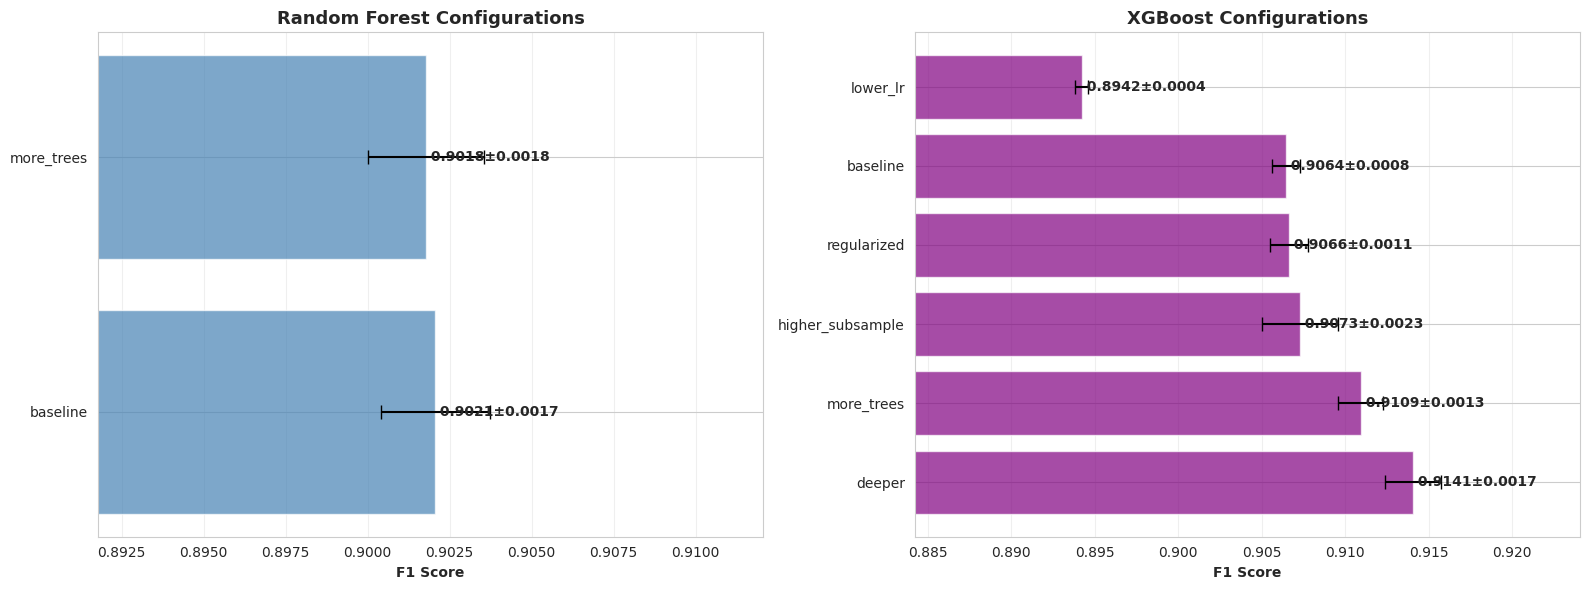


✓ Visualization saved as 'phase2_hyperparameter_refinement.png'

✓ Phase 2 complete. Ready for final test set evaluation.

 Checkpoints saved in 'hyperparameter_checkpoints/' directory
   - If interrupted, re-run this cell to resume from checkpoint


In [ ]:
# ============================================================================
# CELL 7: ADAPTIVE REFINEMENT WITH CHECKPOINTS
# ============================================================================

print("\n" + "="*70)
print("PHASE 2: ADAPTIVE PARAMETER REFINEMENT WITH CHECKPOINTS")
print("="*70)
print("\nStrategy: Test 2 RF configs (slow) vs 6 XGB configs (fast)")
print("Checkpoints allow resuming if interrupted.\n")

import pickle
import os
from pathlib import Path

# Create checkpoint directory
checkpoint_dir = Path('hyperparameter_checkpoints')
checkpoint_dir.mkdir(exist_ok=True)

cv_full = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# ============================================================================
# RANDOM FOREST: Test 2 configurations (it's slow)
# ============================================================================

print("="*70)
print("RANDOM FOREST REFINEMENT (2 configurations)")
print("="*70)

rf_checkpoint_file = checkpoint_dir / 'rf_refinement_results.pkl'

# Check if we have a checkpoint
if rf_checkpoint_file.exists():
    print(" Found Random Forest checkpoint, loading results...")
    with open(rf_checkpoint_file, 'rb') as f:
        rf_results = pickle.load(f)
    print(f"✓ Loaded {len(rf_results)} previously completed RF configurations")
else:
    rf_results = []

base_rf = rf_random.best_params_

rf_configs = [
    ('baseline', base_rf),
    ('more_trees', {**base_rf, 'n_estimators': base_rf.get('n_estimators', 300) + 200}),
]

# Test each RF config
for config_name, params in rf_configs:
    # Check if this config was already tested
    if any(r['name'] == config_name for r in rf_results):
        print(f"\n⏭  Skipping '{config_name}' (already tested)")
        continue

    print(f"\n{'─'*70}")
    print(f"Testing RF Config: {config_name}")
    print(f"Parameters: {params}")
    print(f"{'─'*70}")

    model = RandomForestClassifier(random_state=42, n_jobs=-1, **params)

    print(f"Running 3-fold CV on {len(X_train)} samples...")
    start_time = time.time()

    scores = cross_val_score(
        model, X_train, y_train,
        cv=cv_full,
        scoring='f1',
        n_jobs=-1,
        verbose=1
    )

    elapsed = time.time() - start_time
    mean_f1 = scores.mean()
    std_f1 = scores.std()

    result = {
        'name': config_name,
        'params': params,
        'f1_mean': mean_f1,
        'f1_std': std_f1,
        'f1_scores': scores.tolist(),
        'time_minutes': elapsed / 60
    }

    rf_results.append(result)

    print(f"\n✓ Config '{config_name}' completed in {elapsed/60:.2f} minutes")
    print(f"  F1: {mean_f1:.4f} ± {std_f1:.4f}")

    # Save checkpoint after each config
    with open(rf_checkpoint_file, 'wb') as f:
        pickle.dump(rf_results, f)
    print(f" Checkpoint saved")

# Find best RF config
best_rf = max(rf_results, key=lambda x: x['f1_mean'])

print("\n" + "="*70)
print("RANDOM FOREST RESULTS")
print("="*70)
for result in sorted(rf_results, key=lambda x: x['f1_mean'], reverse=True):
    print(f"  {result['name']:<15}: F1={result['f1_mean']:.4f} ± {result['f1_std']:.4f}  ({result['time_minutes']:.1f} min)")

print(f"\n✓ Best RF: '{best_rf['name']}' with F1={best_rf['f1_mean']:.4f}")

# ============================================================================
# XGBOOST: Test 6 configurations (it's fast)
# ============================================================================

print("\n\n" + "="*70)
print("XGBOOST REFINEMENT (6 configurations)")
print("="*70)

xgb_checkpoint_file = checkpoint_dir / 'xgb_refinement_results.pkl'

# Check if we have a checkpoint
if xgb_checkpoint_file.exists():
    print(" Found XGBoost checkpoint, loading results...")
    with open(xgb_checkpoint_file, 'rb') as f:
        xgb_results = pickle.load(f)
    print(f"✓ Loaded {len(xgb_results)} previously completed XGB configurations")
else:
    xgb_results = []

base_xgb = xgb_random.best_params_

xgb_configs = [
    ('baseline', base_xgb),
    ('more_trees', {**base_xgb, 'n_estimators': base_xgb.get('n_estimators', 300) + 200}),
    ('deeper', {**base_xgb, 'max_depth': min(15, base_xgb.get('max_depth', 7) + 2)}),
    ('lower_lr', {**base_xgb, 'learning_rate': max(0.01, base_xgb.get('learning_rate', 0.1) - 0.05)}),
    ('higher_subsample', {**base_xgb, 'subsample': min(1.0, base_xgb.get('subsample', 0.8) + 0.1)}),
    ('regularized', {**base_xgb, 'reg_alpha': 0.1, 'reg_lambda': 1.0}),
]

# Test each XGB config
for config_name, params in xgb_configs:
    # Check if this config was already tested
    if any(r['name'] == config_name for r in xgb_results):
        print(f"\n⏭  Skipping '{config_name}' (already tested)")
        continue

    print(f"\n{'─'*70}")
    print(f"Testing XGB Config: {config_name}")
    print(f"Parameters: {params}")
    print(f"{'─'*70}")

    model = XGBClassifier(
        random_state=42, n_jobs=-1,
        eval_metric='logloss', verbosity=0,
        **params
    )

    print(f"Running 3-fold CV on {len(X_train)} samples...")
    start_time = time.time()

    scores = cross_val_score(
        model, X_train, y_train,
        cv=cv_full,
        scoring='f1',
        n_jobs=-1,
        verbose=1
    )

    elapsed = time.time() - start_time
    mean_f1 = scores.mean()
    std_f1 = scores.std()

    result = {
        'name': config_name,
        'params': params,
        'f1_mean': mean_f1,
        'f1_std': std_f1,
        'f1_scores': scores.tolist(),
        'time_minutes': elapsed / 60
    }

    xgb_results.append(result)

    print(f"\n✓ Config '{config_name}' completed in {elapsed/60:.2f} minutes")
    print(f"  F1: {mean_f1:.4f} ± {std_f1:.4f}")

    # Save checkpoint after each config
    with open(xgb_checkpoint_file, 'wb') as f:
        pickle.dump(xgb_results, f)
    print(f" Checkpoint saved")

# Find best XGB config
best_xgb = max(xgb_results, key=lambda x: x['f1_mean'])

print("\n" + "="*70)
print("XGBOOST RESULTS")
print("="*70)
for result in sorted(xgb_results, key=lambda x: x['f1_mean'], reverse=True):
    print(f"  {result['name']:<20}: F1={result['f1_mean']:.4f} ± {result['f1_std']:.4f}  ({result['time_minutes']:.1f} min)")

print(f"\n✓ Best XGB: '{best_xgb['name']}' with F1={best_xgb['f1_mean']:.4f}")

# ============================================================================
# FINAL COMPARISON AND SUMMARY
# ============================================================================

print("\n\n" + "="*70)
print("PHASE 2 FINAL SUMMARY")
print("="*70)

total_rf_time = sum(r['time_minutes'] for r in rf_results)
total_xgb_time = sum(r['time_minutes'] for r in xgb_results)

print(f"\nRandom Forest:")
print(f"  Configurations tested: {len(rf_results)}")
print(f"  Best: '{best_rf['name']}'")
print(f"  Best F1: {best_rf['f1_mean']:.4f} ± {best_rf['f1_std']:.4f}")
print(f"  Best parameters: {best_rf['params']}")
print(f"  Total time: {total_rf_time:.2f} minutes")

print(f"\nXGBoost:")
print(f"  Configurations tested: {len(xgb_results)}")
print(f"  Best: '{best_xgb['name']}'")
print(f"  Best F1: {best_xgb['f1_mean']:.4f} ± {best_xgb['f1_std']:.4f}")
print(f"  Best parameters: {best_xgb['params']}")
print(f"  Total time: {total_xgb_time:.2f} minutes")

print(f"\nTotal Phase 2 time: {total_rf_time + total_xgb_time:.2f} minutes")

if best_xgb['f1_mean'] > best_rf['f1_mean']:
    diff = best_xgb['f1_mean'] - best_rf['f1_mean']
    print(f"\n✓ XGBoost leads by {diff:.4f} F1 points")
else:
    diff = best_rf['f1_mean'] - best_xgb['f1_mean']
    print(f"\n✓ Random Forest leads by {diff:.4f} F1 points")

# Create comparison visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# RF comparison
rf_names = [r['name'] for r in sorted(rf_results, key=lambda x: x['f1_mean'], reverse=True)]
rf_means = [r['f1_mean'] for r in sorted(rf_results, key=lambda x: x['f1_mean'], reverse=True)]
rf_stds = [r['f1_std'] for r in sorted(rf_results, key=lambda x: x['f1_mean'], reverse=True)]

ax1.barh(rf_names, rf_means, xerr=rf_stds, capsize=5, color='steelblue', alpha=0.7)
ax1.set_xlabel('F1 Score', fontweight='bold')
ax1.set_title('Random Forest Configurations', fontweight='bold', fontsize=13)
ax1.set_xlim([min(rf_means)-0.01, max(rf_means)+0.01])
ax1.grid(True, alpha=0.3, axis='x')

# Add value labels
for i, (mean, std) in enumerate(zip(rf_means, rf_stds)):
    ax1.text(mean, i, f' {mean:.4f}±{std:.4f}',
            va='center', fontsize=10, fontweight='bold')

# XGB comparison
xgb_names = [r['name'] for r in sorted(xgb_results, key=lambda x: x['f1_mean'], reverse=True)]
xgb_means = [r['f1_mean'] for r in sorted(xgb_results, key=lambda x: x['f1_mean'], reverse=True)]
xgb_stds = [r['f1_std'] for r in sorted(xgb_results, key=lambda x: x['f1_mean'], reverse=True)]

ax2.barh(xgb_names, xgb_means, xerr=xgb_stds, capsize=5, color='purple', alpha=0.7)
ax2.set_xlabel('F1 Score', fontweight='bold')
ax2.set_title('XGBoost Configurations', fontweight='bold', fontsize=13)
ax2.set_xlim([min(xgb_means)-0.01, max(xgb_means)+0.01])
ax2.grid(True, alpha=0.3, axis='x')

# Add value labels
for i, (mean, std) in enumerate(zip(xgb_means, xgb_stds)):
    ax2.text(mean, i, f' {mean:.4f}±{std:.4f}',
            va='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig('phase2_hyperparameter_refinement.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Visualization saved as 'phase2_hyperparameter_refinement.png'")

# Create mock grid objects for compatibility with later cells
class RefinedModel:
    def __init__(self, params, score, std):
        self.best_params_ = params
        self.best_score_ = score
        self.best_score_std_ = std
        self.best_estimator_ = None

rf_grid = RefinedModel(
    best_rf['params'],
    best_rf['f1_mean'],
    best_rf['f1_std']
)
rf_grid.best_estimator_ = RandomForestClassifier(random_state=42, n_jobs=-1, **best_rf['params'])

xgb_grid = RefinedModel(
    best_xgb['params'],
    best_xgb['f1_mean'],
    best_xgb['f1_std']
)
xgb_grid.best_estimator_ = XGBClassifier(
    random_state=42, n_jobs=-1, eval_metric='logloss',
    verbosity=0, **best_xgb['params']
)

print("\n✓ Phase 2 complete. Ready for final test set evaluation.")
print(f"\n Checkpoints saved in '{checkpoint_dir}/' directory")
print("   - If interrupted, re-run this cell to resume from checkpoint")

In [ ]:
# ============================================================================
# CELL 8: FINAL HEAD-TO-HEAD COMPARISON
# ============================================================================

print("\n" + "="*70)
print("PHASE 3: FINAL HEAD-TO-HEAD EVALUATION")
print("="*70)
print("\nUsing optimized parameters with 5-fold CV for final comparison.\n")

cv_final = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Get best models
rf_best = rf_grid.best_estimator_
xgb_best = xgb_grid.best_estimator_

# Detailed evaluation function
def detailed_evaluation(model, X, y, cv, model_name):
    """Perform comprehensive evaluation"""
    print(f"\nEvaluating {model_name}...")

    results = {
        'accuracy': [],
        'f1': [],
        'roc_auc': [],
        'precision': [],
        'recall': []
    }

    all_y_true = []
    all_y_pred = []
    all_y_proba = []

    for fold_idx, (train_idx, val_idx) in enumerate(cv.split(X, y)):
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        # Train
        model.fit(X_train, y_train)

        # Predict
        y_pred = model.predict(X_val)
        y_proba = model.predict_proba(X_val)[:, 1]

        # Store predictions
        all_y_true.extend(y_val)
        all_y_pred.extend(y_pred)
        all_y_proba.extend(y_proba)

        # Calculate metrics
        from sklearn.metrics import precision_score, recall_score
        results['accuracy'].append(accuracy_score(y_val, y_pred))
        results['f1'].append(f1_score(y_val, y_pred))
        results['roc_auc'].append(roc_auc_score(y_val, y_proba))
        results['precision'].append(precision_score(y_val, y_pred))
        results['recall'].append(recall_score(y_val, y_pred))

        print(f"  Fold {fold_idx + 1}: F1={results['f1'][-1]:.4f}")

    # Convert to numpy arrays
    for key in results:
        results[key] = np.array(results[key])

    return results, all_y_true, all_y_pred, all_y_proba

# Evaluate both models
rf_results, rf_y_true, rf_y_pred, rf_y_proba = detailed_evaluation(
    rf_best, X, y, cv_final, "Random Forest (Optimized)"
)

xgb_results, xgb_y_true, xgb_y_pred, xgb_y_proba = detailed_evaluation(
    xgb_best, X, y, cv_final, "XGBoost (Optimized)"
)

# Create comparison DataFrame
comparison_df = pd.DataFrame({
    'Metric': ['Accuracy', 'F1 Score', 'ROC-AUC', 'Precision', 'Recall'],
    'RF Mean': [rf_results['accuracy'].mean(), rf_results['f1'].mean(),
                rf_results['roc_auc'].mean(), rf_results['precision'].mean(),
                rf_results['recall'].mean()],
    'RF Std': [rf_results['accuracy'].std(), rf_results['f1'].std(),
               rf_results['roc_auc'].std(), rf_results['precision'].std(),
               rf_results['recall'].std()],
    'XGB Mean': [xgb_results['accuracy'].mean(), xgb_results['f1'].mean(),
                 xgb_results['roc_auc'].mean(), xgb_results['precision'].mean(),
                 xgb_results['recall'].mean()],
    'XGB Std': [xgb_results['accuracy'].std(), xgb_results['f1'].std(),
                xgb_results['roc_auc'].std(), xgb_results['precision'].std(),
                xgb_results['recall'].std()]
})

print("\n" + "="*70)
print("FINAL COMPARISON TABLE")
print("="*70)
print(comparison_df.to_string(index=False))

# Calculate differences
comparison_df['Difference (XGB - RF)'] = comparison_df['XGB Mean'] - comparison_df['RF Mean']
print("\n" + "-"*70)
print("Performance Differences (XGBoost - Random Forest):")
print("-"*70)
for idx, row in comparison_df.iterrows():
    metric = row['Metric']
    diff = row['Difference (XGB - RF)']
    print(f"{metric:<15}: {diff:+.4f}")


PHASE 3: FINAL HEAD-TO-HEAD EVALUATION

Using optimized parameters with 5-fold CV for final comparison.


Evaluating Random Forest (Optimized)...
  Fold 1: F1=0.9131
  Fold 2: F1=0.9114
  Fold 3: F1=0.9152
  Fold 4: F1=0.9106
  Fold 5: F1=0.9134

Evaluating XGBoost (Optimized)...
  Fold 1: F1=0.9211
  Fold 2: F1=0.9203
  Fold 3: F1=0.9259
  Fold 4: F1=0.9213
  Fold 5: F1=0.9208

FINAL COMPARISON TABLE
   Metric  RF Mean   RF Std  XGB Mean  XGB Std
 Accuracy 0.914550 0.001568  0.923417 0.001929
 F1 Score 0.912754 0.001613  0.921899 0.002015
  ROC-AUC 0.977621 0.000661  0.978813 0.001305
Precision 0.932351 0.001860  0.940528 0.002205
   Recall 0.893967 0.002042  0.904000 0.003031

----------------------------------------------------------------------
Performance Differences (XGBoost - Random Forest):
----------------------------------------------------------------------
Accuracy       : +0.0089
F1 Score       : +0.0091
ROC-AUC        : +0.0012
Precision      : +0.0082
Recall         : +


Generating comparison visualizations...



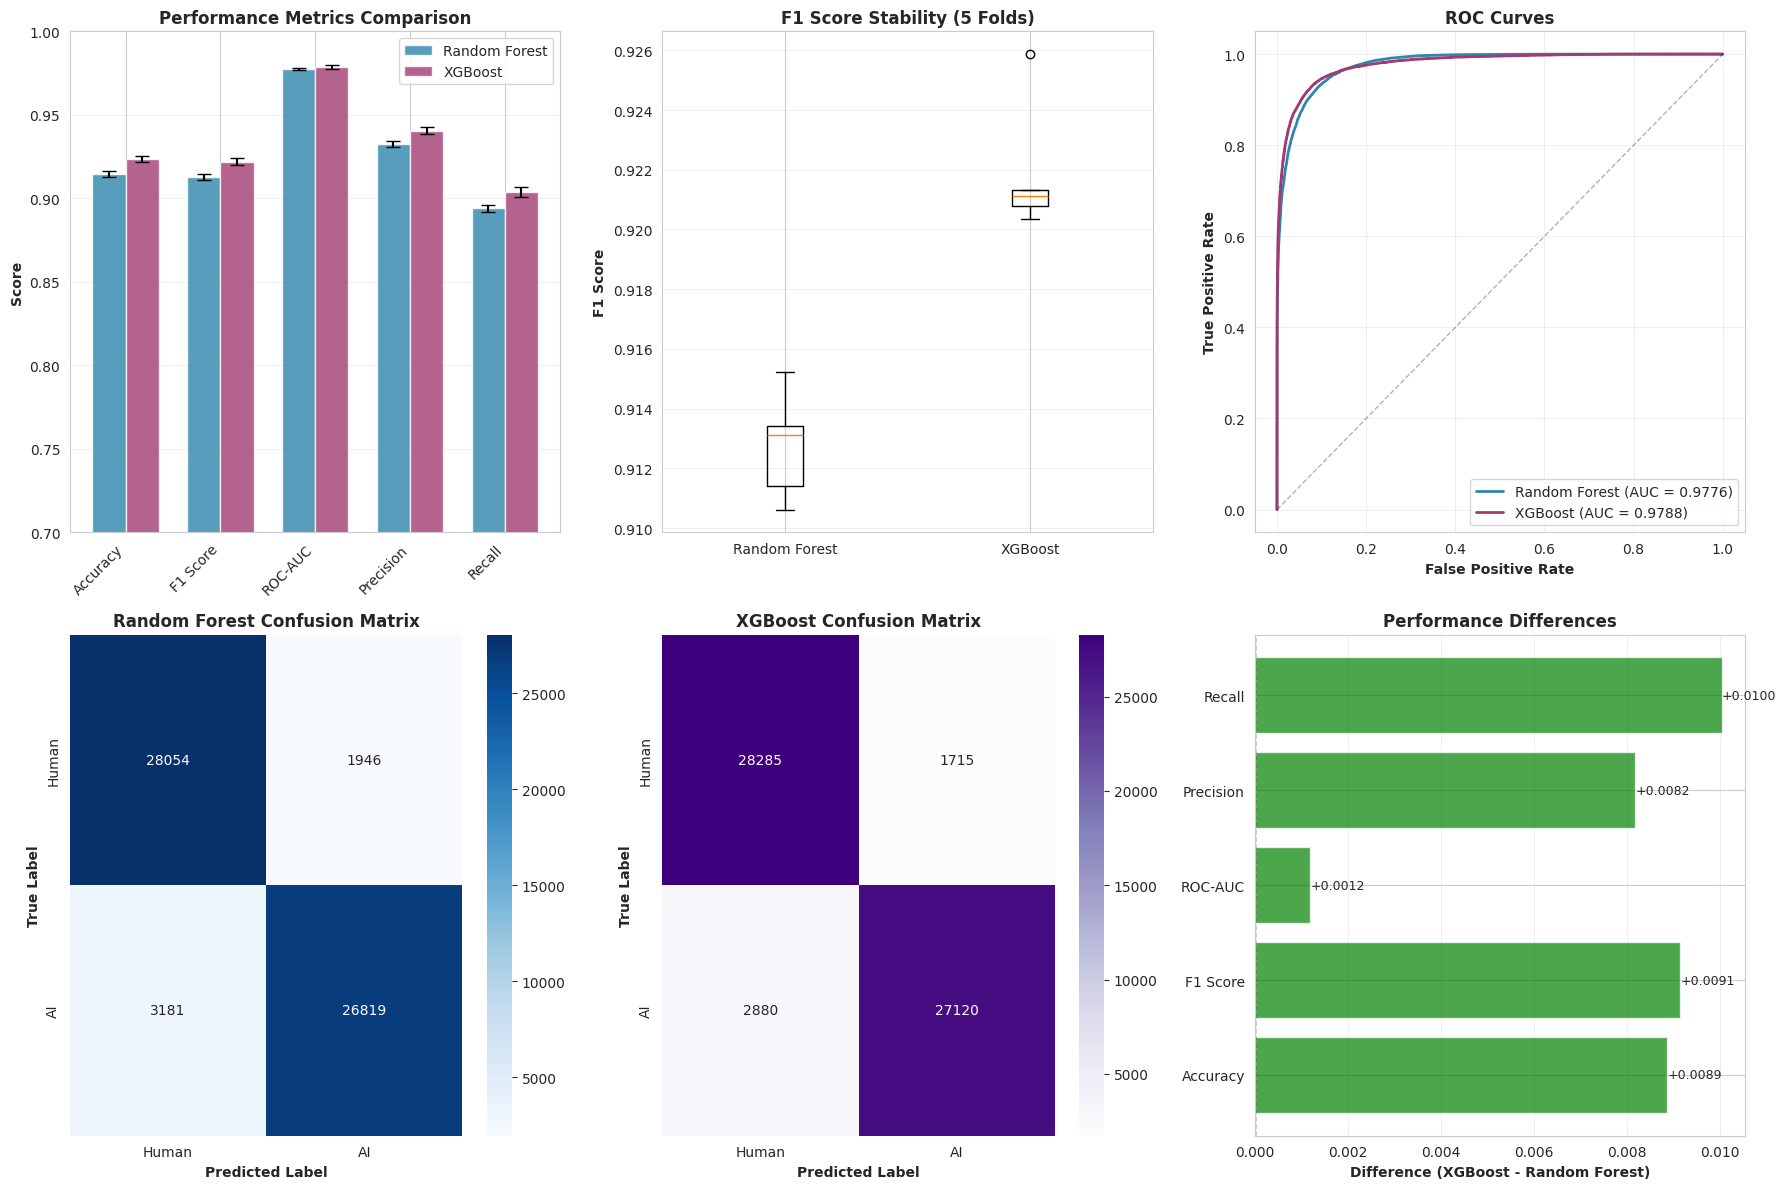

In [ ]:
# ============================================================================
# CELL 9: VISUALIZATION COMPARISON
# ============================================================================

print("\nGenerating comparison visualizations...\n")

fig = plt.figure(figsize=(18, 12))

# 1. Performance metrics comparison
ax1 = plt.subplot(2, 3, 1)
metrics = ['Accuracy', 'F1 Score', 'ROC-AUC', 'Precision', 'Recall']
rf_means = comparison_df['RF Mean'].values
xgb_means = comparison_df['XGB Mean'].values
rf_stds = comparison_df['RF Std'].values
xgb_stds = comparison_df['XGB Std'].values

x = np.arange(len(metrics))
width = 0.35

bars1 = ax1.bar(x - width/2, rf_means, width, yerr=rf_stds,
                label='Random Forest', alpha=0.8, capsize=5, color='#2E86AB')
bars2 = ax1.bar(x + width/2, xgb_means, width, yerr=xgb_stds,
                label='XGBoost', alpha=0.8, capsize=5, color='#A23B72')

ax1.set_ylabel('Score', fontweight='bold')
ax1.set_title('Performance Metrics Comparison', fontweight='bold', fontsize=12)
ax1.set_xticks(x)
ax1.set_xticklabels(metrics, rotation=45, ha='right')
ax1.legend()
ax1.grid(True, alpha=0.3, axis='y')
ax1.set_ylim([0.7, 1.0])

# 2. F1 Score distribution across folds
ax2 = plt.subplot(2, 3, 2)
ax2.boxplot([rf_results['f1'], xgb_results['f1']],
            labels=['Random Forest', 'XGBoost'])
ax2.set_ylabel('F1 Score', fontweight='bold')
ax2.set_title('F1 Score Stability (5 Folds)', fontweight='bold', fontsize=12)
ax2.grid(True, alpha=0.3, axis='y')

# 3. ROC Curves
ax3 = plt.subplot(2, 3, 3)
from sklearn.metrics import roc_curve, auc

rf_fpr, rf_tpr, _ = roc_curve(rf_y_true, rf_y_proba)
xgb_fpr, xgb_tpr, _ = roc_curve(xgb_y_true, xgb_y_proba)

rf_auc = auc(rf_fpr, rf_tpr)
xgb_auc = auc(xgb_fpr, xgb_tpr)

ax3.plot(rf_fpr, rf_tpr, color='#2E86AB', lw=2,
         label=f'Random Forest (AUC = {rf_auc:.4f})')
ax3.plot(xgb_fpr, xgb_tpr, color='#A23B72', lw=2,
         label=f'XGBoost (AUC = {xgb_auc:.4f})')
ax3.plot([0, 1], [0, 1], 'k--', lw=1, alpha=0.3)
ax3.set_xlabel('False Positive Rate', fontweight='bold')
ax3.set_ylabel('True Positive Rate', fontweight='bold')
ax3.set_title('ROC Curves', fontweight='bold', fontsize=12)
ax3.legend(loc='lower right')
ax3.grid(True, alpha=0.3)

# 4. Confusion Matrix - Random Forest
ax4 = plt.subplot(2, 3, 4)
from sklearn.metrics import confusion_matrix
rf_cm = confusion_matrix(rf_y_true, rf_y_pred)
sns.heatmap(rf_cm, annot=True, fmt='d', cmap='Blues', ax=ax4,
            xticklabels=['Human', 'AI'], yticklabels=['Human', 'AI'])
ax4.set_ylabel('True Label', fontweight='bold')
ax4.set_xlabel('Predicted Label', fontweight='bold')
ax4.set_title('Random Forest Confusion Matrix', fontweight='bold', fontsize=12)

# 5. Confusion Matrix - XGBoost
ax5 = plt.subplot(2, 3, 5)
xgb_cm = confusion_matrix(xgb_y_true, xgb_y_pred)
sns.heatmap(xgb_cm, annot=True, fmt='d', cmap='Purples', ax=ax5,
            xticklabels=['Human', 'AI'], yticklabels=['Human', 'AI'])
ax5.set_ylabel('True Label', fontweight='bold')
ax5.set_xlabel('Predicted Label', fontweight='bold')
ax5.set_title('XGBoost Confusion Matrix', fontweight='bold', fontsize=12)

# 6. Performance difference visualization
ax6 = plt.subplot(2, 3, 6)
differences = comparison_df['Difference (XGB - RF)'].values
colors = ['green' if x > 0 else 'red' for x in differences]
bars = ax6.barh(metrics, differences, color=colors, alpha=0.7)
ax6.axvline(x=0, color='black', linestyle='--', linewidth=1)
ax6.set_xlabel('Difference (XGBoost - Random Forest)', fontweight='bold')
ax6.set_title('Performance Differences', fontweight='bold', fontsize=12)
ax6.grid(True, alpha=0.3, axis='x')

# Add value labels
for i, (bar, val) in enumerate(zip(bars, differences)):
    ax6.text(val, i, f'{val:+.4f}',
            va='center', ha='left' if val > 0 else 'right', fontsize=9)

plt.tight_layout()
plt.show()